# Manejo de datos raster

## Descripción general

En este capítulo, se muestran ejemplos de manejo de datos raster con Python.

Los datos se obtienen de servicios basados en [SpatioTemporal Asset Catalogs (STAC)](https://stacspec.org). STAC es una especificación que proporciona una estructura común para describir y catalogar recursos espacio temporales (ej. imágenes satelitales). Puede explorar catálogos STAC con [STAC browser](https://radiantearth.github.io/stac-browser/).

Algunas de los módulos que se utilizan en este capítulo son:

- [rasterio](https://rasterio.readthedocs.io/): para operaciones generales de manejo de datos raster.
- [pystac_client](https://pystac-client.readthedocs.io/): para trabajar con catálogos STAC.
- [rioxarray](https://corteva.github.io/rioxarray/stable/): extensión de [xarray](https://docs.xarray.dev/en/stable/) para trabajar con rasterio. 

## Instalación de módulos

```
mamba install -c conda-forge xarray rioxarray earthpy xarray-spatial pystac-client python-graphviz
```

## Acceso a datos raster

In [1]:
# Carga de pystac_client
from pystac_client import Client

In [2]:
# URL de un catálogo STAC
api_url = "https://earth-search.aws.element84.com/v0"

client = Client.open(api_url)

In [3]:
# Colección
collection = "sentinel-s2-l2a-cogs"  # Sentinel-2, Nivel 2A, COG

In [4]:
# Punto para búsqueda
from shapely.geometry import Point
point = Point(-84, 10)

In [5]:
# Búsqueda de items (imágenes) que contienen el punto
search = client.search(collections=[collection],
                       intersects=point,
                       max_items=10,
)

In [6]:
# Cantidad total de items que retorna la búsqueda
search.matched()

365

In [7]:
# Items retornados
items = search.get_all_items()

len(items)

10

In [8]:
# Identificadores de los items retornados
for item in items:
    print(item)

<Item id=S2A_16PHS_20221106_0_L2A>
<Item id=S2B_16PHS_20221101_0_L2A>
<Item id=S2A_16PHS_20221027_0_L2A>
<Item id=S2B_16PHS_20221022_0_L2A>
<Item id=S2B_16PHS_20221012_0_L2A>
<Item id=S2A_16PHS_20221007_0_L2A>
<Item id=S2B_16PHS_20221002_0_L2A>
<Item id=S2A_16PHS_20220927_0_L2A>
<Item id=S2B_16PHS_20220922_0_L2A>
<Item id=S2A_16PHS_20220917_0_L2A>


In [9]:
# Primer item (imagen) retornado
item = items[0]

In [10]:
# Algunos atributos del item
print(item.datetime)
print(item.geometry)
print(item.properties)

2022-11-06 16:10:36+00:00
{'type': 'Polygon', 'coordinates': [[[-83.26529071959975, 9.841749072035094], [-84.26505426889273, 9.85133238997552], [-84.2564449365329, 10.843245515578994], [-83.25354975084628, 10.83267581874028], [-83.26529071959975, 9.841749072035094]]]}
{'datetime': '2022-11-06T16:10:36Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'gsd': 10, 'view:off_nadir': 0, 'proj:epsg': 32616, 'sentinel:utm_zone': 16, 'sentinel:latitude_band': 'P', 'sentinel:grid_square': 'HS', 'sentinel:sequence': '0', 'sentinel:product_id': 'S2A_MSIL2A_20221106T160521_N0400_R054_T16PHS_20221106T210655', 'sentinel:data_coverage': 100, 'eo:cloud_cover': 84.72, 'sentinel:valid_cloud_cover': True, 'sentinel:processing_baseline': '04.00', 'sentinel:boa_offset_applied': True, 'created': '2022-11-06T23:15:01.882Z', 'updated': '2022-11-06T23:15:01.882Z'}


In [11]:
# Rectángulo para búsquedas
bbox = point.buffer(0.01).bounds
bbox

(-84.01, 9.99, -83.99, 10.01)

In [12]:
# Búsqueda con nuevos criterios
search = client.search(collections=[collection],
                       bbox=bbox,
                       datetime="2022-01-01/2022-11-30",
                       query=["eo:cloud_cover<10"]) # no deben haber espacios alrededor del '<'

# Cantidad total de items que retorna la búsqueda
search.matched()

5

In [13]:
# Items retornados
items = search.get_all_items()

len(items)

5

In [14]:
# Segundo item y algunos de sus atributos
item = items[1]

print(item.datetime)
print(item.properties)

2022-06-04 16:10:32+00:00
{'datetime': '2022-06-04T16:10:32Z', 'platform': 'sentinel-2b', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'gsd': 10, 'view:off_nadir': 0, 'proj:epsg': 32616, 'sentinel:utm_zone': 16, 'sentinel:latitude_band': 'P', 'sentinel:grid_square': 'HS', 'sentinel:sequence': '0', 'sentinel:product_id': 'S2B_MSIL2A_20220604T160509_N0400_R054_T16PHS_20220604T202130', 'sentinel:data_coverage': 100, 'eo:cloud_cover': 5.33, 'sentinel:valid_cloud_cover': True, 'sentinel:processing_baseline': '04.00', 'sentinel:boa_offset_applied': True, 'created': '2022-06-05T01:47:01.875Z', 'updated': '2022-06-05T01:47:01.875Z'}


In [15]:
# Activos (assets) del item
assets = item.assets

# Llaves
assets.keys()

dict_keys(['thumbnail', 'overview', 'info', 'metadata', 'visual', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'AOT', 'WVP', 'SCL'])

In [16]:
assets.items()

dict_items([('thumbnail', <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/16/P/HS/2022/6/4/0/preview.jpg>), ('overview', <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/L2A_PVI.tif>), ('info', <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/16/P/HS/2022/6/4/0/tileInfo.json>), ('metadata', <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/16/P/HS/2022/6/4/0/metadata.xml>), ('visual', <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/TCI.tif>), ('B01', <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/B01.tif>), ('B02', <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/B02.tif>), ('B03', <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s

In [17]:
# Nombres de los activos
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

thumbnail: Thumbnail
overview: True color image
info: Original JSON metadata
metadata: Original XML metadata
visual: True color image
B01: Band 1 (coastal)
B02: Band 2 (blue)
B03: Band 3 (green)
B04: Band 4 (red)
B05: Band 5
B06: Band 6
B07: Band 7
B08: Band 8 (nir)
B8A: Band 8A
B09: Band 9
B11: Band 11 (swir16)
B12: Band 12 (swir22)
AOT: Aerosol Optical Thickness (AOT)
WVP: Water Vapour (WVP)
SCL: Scene Classification Map (SCL)


In [18]:
# Imagen thumbnail
assets["thumbnail"]

href: https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/16/P/HS/2022/6/4/0/preview.jpg
Title: Thumbnail
Media type: image/png
Roles: ['thumbnail']
Owner:


In [19]:
# Dirección del thumbnail
assets["thumbnail"].href

'https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/16/P/HS/2022/6/4/0/preview.jpg'

In [20]:
import rioxarray

In [21]:
# Dirección de la banda 9
b09_href = assets["B09"].href
b09_href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/B09.tif'

In [22]:
# Banda 9
b09 = rioxarray.open_rasterio(b09_href)
b09

<xarray.DataArray (band: 1, y: 1830, x: 1830)>
[3348900 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 8e+05 8.001e+05 8.001e+05 ... 9.097e+05 9.098e+05
  * y            (y) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.09e+06 1.09e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [23]:
b09.values

array([[[ 4460,  3993,  4132, ...,     1,     1,     1],
        [ 4102,  3984,  4099, ...,    55,    51,     1],
        [ 4110,  4220,  4212, ...,    83,    62,     1],
        ...,
        [ 3990,  3931,  4134, ..., 14362, 14122, 12707],
        [ 3990,  3776,  4068, ..., 14430, 13658, 12008],
        [ 4264,  4018,  3886, ..., 12121, 11158, 10160]]], dtype=uint16)

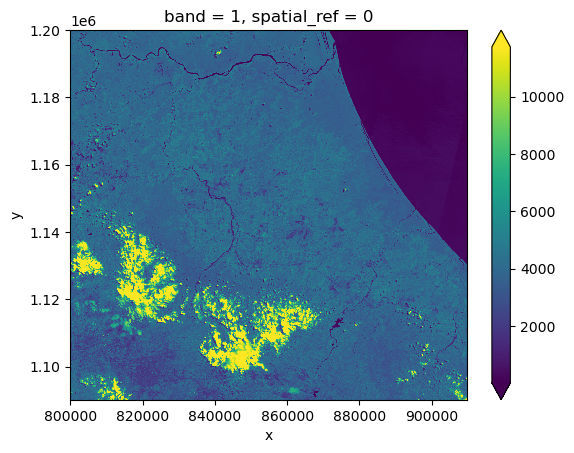

In [24]:
# Graficación de la banda
b09.plot(robust=True)

In [25]:
# Vista general de la imagen (True Color)
overview = rioxarray.open_rasterio(item.assets['overview'].href)
overview

<xarray.DataArray (band: 3, y: 343, x: 343)>
[352947 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 8.001e+05 8.005e+05 ... 9.093e+05 9.096e+05
  * y            (y) float64 1.2e+06 1.2e+06 1.199e+06 ... 1.091e+06 1.09e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [26]:
overview.shape

(3, 343, 343)

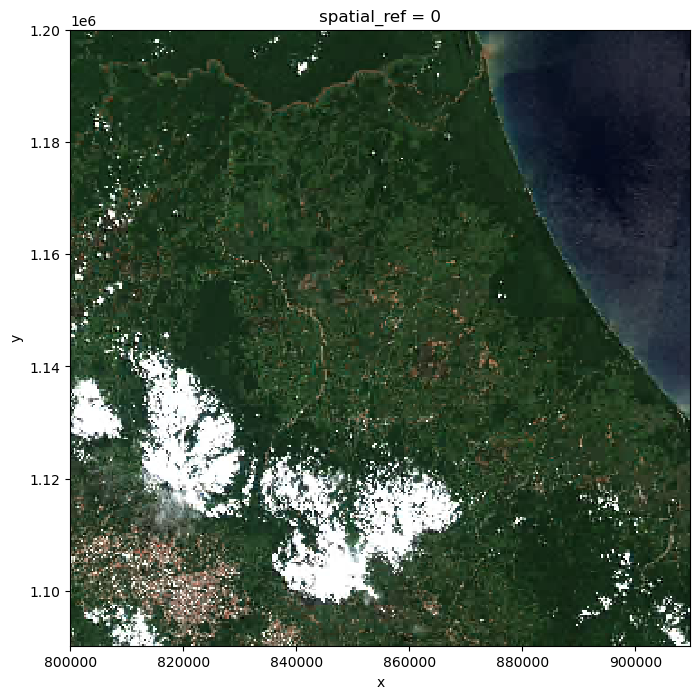

In [27]:
overview.plot.imshow(figsize=(8, 8))

## Cálculo del NDVI

In [28]:
# Bandas necesarias para el cálculos
b_red = rioxarray.open_rasterio(assets["B04"].href)
b_nir = rioxarray.open_rasterio(assets["B8A"].href)

In [29]:
# Se reduce el área de cálculo
point = Point(859872, 1168852)
bbox = point.buffer(15000).bounds

b_red_clip = b_red.rio.clip_box(*bbox)
b_nir_clip = b_nir.rio.clip_box(*bbox)

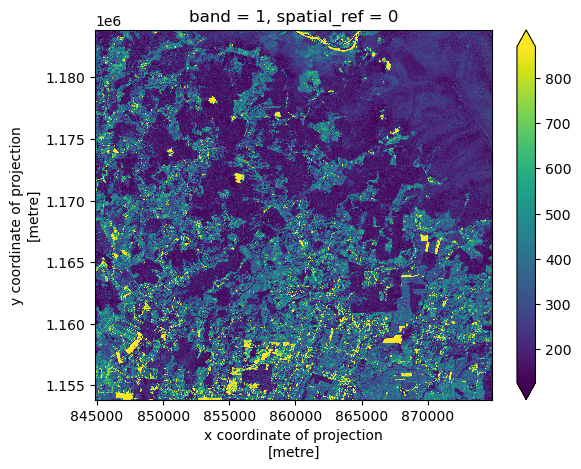

In [30]:
b_red_clip.plot(robust=True)

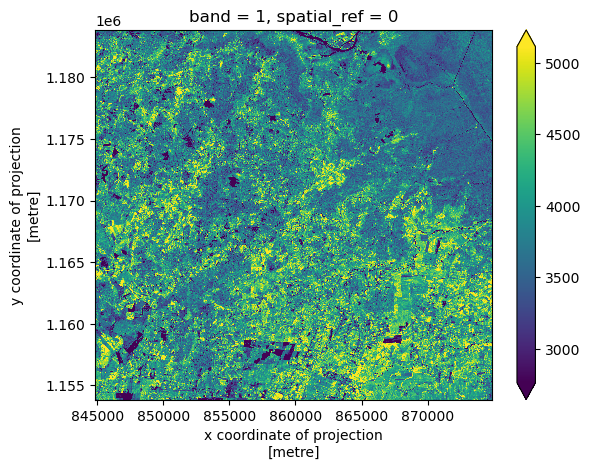

In [31]:
b_nir_clip.plot(robust=True)

In [32]:
# Dimensiones de las bandas
print(b_red_clip.shape, b_nir_clip.shape)

(1, 3001, 3001) (1, 1501, 1501)


In [33]:
# Se homogenizan las dimensiones
b_red_clip_matched = b_red_clip.rio.reproject_match(b_nir_clip)
print(b_red_clip_matched.shape)

(1, 1501, 1501)


In [34]:
# Cálculo del NDVI
ndvi = (b_nir_clip - b_red_clip_matched)/ (b_nir_clip + b_red_clip_matched)
print(ndvi)

<xarray.DataArray (band: 1, y: 1501, x: 1501)>
array([[[0.91660151, 0.91400322, 0.89911596, ..., 0.89431505,
         0.88412229, 0.88840737],
        [0.90833826, 0.91062614, 0.91152318, ..., 0.88863463,
         0.89484536, 0.892044  ],
        [0.92563213, 0.91899371, 0.93272962, ..., 0.8851302 ,
         0.87897934, 0.89033189],
        ...,
        [0.87303852, 0.84974781, 0.87110989, ..., 0.9123506 ,
         0.90405513, 0.92036103],
        [0.88441876, 0.89774273, 0.89312977, ..., 0.91395593,
         0.90356851, 0.92123382],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 8.449e+05 8.449e+05 ... 8.748e+05 8.749e+05
  * y            (y) float64 1.184e+06 1.184e+06 ... 1.154e+06 1.154e+06
    spatial_ref  int64 0


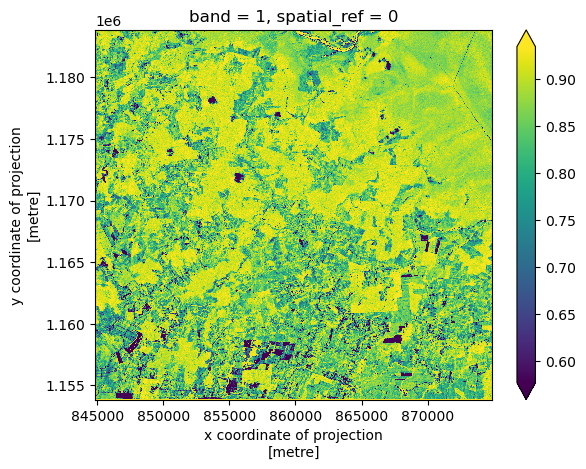

In [35]:
ndvi.plot(robust=True)

In [36]:
# Se guarda el resultado en un archivo
# ndvi.rio.to_raster("ndvi.tif")

## Recursos de interés

- [The Carpentries Incubator - Introduction to Geospatial Raster and Vector Data with Python](https://carpentries-incubator.github.io/geospatial-python/)
- [Geospatial Raster & Vector Data with Python](https://www.youtube.com/watch?v=Ce7GuGIf3r0)